Lowest gas price in the last hour: 0.757130064 Gwei at 2025-03-02 23:29:42.524145+00:00
Expected lowest gas price in next 10 minutes: 1.39 Gwei at 2025-03-03 00:16:39.052528+00:00


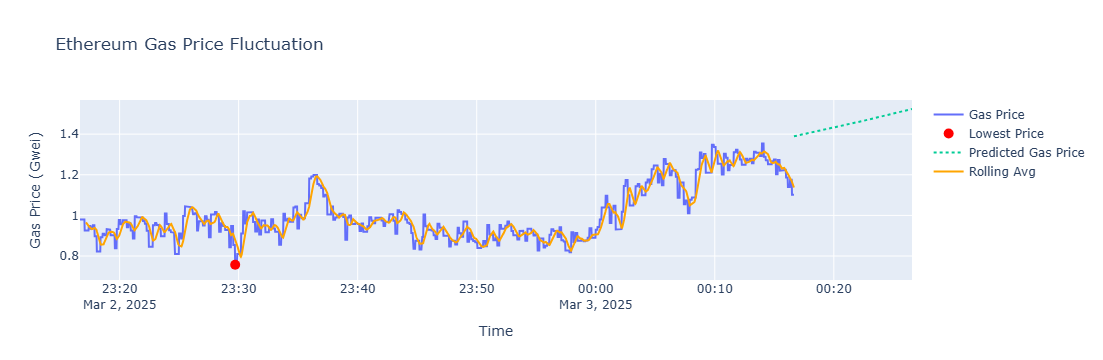

Gas price data saved to gasprices.csv


In [ ]:
import requests
import pandas as pd
import time
import plotly.graph_objects as go
import datetime
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

# Etherscan API setup
ETHERSCAN_API_KEY = "Please input your API key"
GAS_API_URL = f"https://api.etherscan.io/api?module=gastracker&action=gasoracle&apikey={ETHERSCAN_API_KEY}"

# Storage for gas prices
gas_data = []

def fetch_gas_price():
    """Fetch gas price from Etherscan API with retry mechanism."""
    for _ in range(3):  # Retry up to 3 times
        try:
            response = requests.get(GAS_API_URL, timeout=5).json()
            gas_price = float(response['result']['SafeGasPrice'])
            timestamp = datetime.datetime.now(datetime.UTC)  # Updated line
            return timestamp, gas_price
        except Exception as e:
            print(f"Error fetching gas price, retrying... ({e})")
            time.sleep(2)  # Wait before retrying
    return None, None


# Collect gas prices for 3 hours
start_time = time.time()
while time.time() - start_time < 10800:
    timestamp, gas_price = fetch_gas_price()
    if gas_price:
        gas_data.append((timestamp, gas_price))
    time.sleep(0.5)

# Convert to DataFrame
df = pd.DataFrame(gas_data, columns=["Timestamp", "GasPrice"])

# Find lowest gas price
min_gas_row = df.loc[df['GasPrice'].idxmin()]
min_gas_time = min_gas_row["Timestamp"]
min_gas_price = min_gas_row["GasPrice"]
print(f"Lowest gas price in the last hour: {min_gas_price} Gwei at {min_gas_time}")

# Prepare data for prediction
X = np.array(range(len(df))).reshape(-1, 1)
y = df['GasPrice'].values

# Use Polynomial Regression for better predictions
model = make_pipeline(PolynomialFeatures(degree=3), LinearRegression())
model.fit(X, y)

# Predict next 10 minutes (120 points, every 5 sec)
predict_timestamps = [df['Timestamp'].iloc[-1] + datetime.timedelta(seconds=i*5) for i in range(120)]
predict_X = np.array(range(len(df), len(df) + 120)).reshape(-1, 1)
predicted_gas = model.predict(predict_X)

# Find expected lowest gas price in next 10 minutes
min_predicted_price = np.min(predicted_gas)
min_predicted_time = predict_timestamps[np.argmin(predicted_gas)]
print(f"Expected lowest gas price in next 10 minutes: {min_predicted_price:.2f} Gwei at {min_predicted_time}")

# Visualization
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Timestamp'], y=df['GasPrice'], mode='lines', name='Gas Price'))
fig.add_trace(go.Scatter(x=[min_gas_time], y=[min_gas_price], mode='markers', marker=dict(color='red', size=10), name='Lowest Price'))
fig.add_trace(go.Scatter(x=predict_timestamps, y=predicted_gas, mode='lines', name='Predicted Gas Price', line=dict(dash='dot')))
fig.add_trace(go.Scatter(x=df['Timestamp'], y=df['GasPrice'].rolling(20).mean(), mode='lines', name='Rolling Avg', line=dict(color='orange')))

fig.update_layout(title='Ethereum Gas Price Fluctuation', xaxis_title='Time', yaxis_title='Gas Price (Gwei)', xaxis=dict(showgrid=True), yaxis=dict(showgrid=True))
fig.show()

# Save to CSV
df.to_csv("gasprices.csv", index=False)
print("Gas price data saved to gasprices.csv")
